In [ ]:
import re
import os
import difflib
import requests
import sklearn.neighbors
import numpy as np
import pandas as pd
import seaborn as sns
from time import sleep
from bs4 import BeautifulSoup

# Scrape WalkHighlands

In [ ]:
MY_HEADER = {'user-agent': 'Filip Balucha (s1913040@ed.ac.uk)'}
URL_WALKHIGHLANDS = 'https://www.walkhighlands.co.uk/'

## 1. Scrape [munro tables](https://www.walkhighlands.co.uk/munros/)

In [ ]:
def cache(subpage, cache_path):
    print(f'Downloading: {subpage}')
    url = URL_WALKHIGHLANDS + subpage
    r = requests.get(url, headers=MY_HEADER)
    sleep(10)  # prevent many requests in a row
    
    if r.status_code != 200:
        print(f'Error: {r.status_code}')
        raise

    # Store HTML in cache
    os.makedirs(os.path.dirname(cache_path), exist_ok=True)  # create a new directory if necessary
    with open(cache_path, 'wb') as out:
        out.write(r.content)
        print('Success!\n')

def load_from_cache(subpage):
    cache_path = os.path.join('cache', subpage + '.html')
    if not os.path.isfile(cache_path):  # not yet cached
        cache(subpage, cache_path)
    return cache_path

def request(subpage):
    cache_path = load_from_cache(subpage)
    with open(cache_path, 'r') as f:
        contents = f.read()    
        soup = BeautifulSoup(contents, 'html.parser')
    return soup

In [ ]:
def parse_table(soup, field_name, details, val_parser=str):
    for table_column in soup.find_all('tbody'):
        for row in table_column.find_all('tr'):
            # Parse table row
            row_fields = row.find_all('td')
            name_field, val_field = row_fields[-2:]  # take last two fields
            name = name_field.a.contents[0]
            val = val_field.contents[0]
            if name not in details:
                details[name] = {}
            if 'href' not in details[name]:  # add munro hyperlink
                details[name]['href'] = 'munros/' + name_field.a['href']
            details[name][field_name] = val_parser(val)

In [ ]:
munro_details = {}

### Munros by altitude

In [ ]:
subpage = 'munros/munros-height'
soup = request(subpage)

In [ ]:
remove_unit = lambda x: int(str(x).replace('m',''))
parse_table(soup, 'altitude', munro_details, val_parser=remove_unit)

### Munros by most climbed

In [ ]:
subpage = 'munros/most-climbed'
soup = request(subpage)

In [ ]:
parse_table(soup, 'ascent_count', munro_details, val_parser=int)

### Munros by rating

In [ ]:
subpage = 'munros/munros-by-rating'
soup = request(subpage)

In [ ]:
parse_table(soup, 'rating', munro_details, val_parser=float)

### Munros by region

In [ ]:
subpage = 'munros/munros-region'
soup = request(subpage)

In [ ]:
parse_table(soup, 'region', munro_details)

### Munros by report count

In [ ]:
subpage = 'munros/most-reports'
soup = request(subpage)

In [ ]:
parse_table(soup, 'report_count', munro_details, val_parser=int)

### Extract number of ratings for each munro

In [ ]:
for data in munro_details.values():
    soup = request(data['href'])
    rating_count = int(soup.find("span", itemprop='ratingCount').contents[0])
    data['rating_count'] = rating_count

## 2. Create a dataframe

In [ ]:
# Convert WalkHighlands data to pandas dataframe
df_wh = pd.DataFrame.from_dict(munro_details, orient='index')
df_wh.head()

,href,altitude,ascent_count,rating,region,report_count,rating_count
Ben Nevis,munros/ben-nevis,1345,17902,3.90,Fort William,316,253
Ben Macdui,munros/ben-macdui,1309,10449,3.85,Cairngorms,215,162
Braeriach,munros/braeriach,1296,6035,4.18,Cairngorms,141,94
Cairn Toul,munros/cairn-toul,1291,5121,4.04,Cairngorms,136,83
Sgor an Lochain Uaine,munros/sgor-an-lochain-uaine,1258,4832,4.01,Cairngorms,139,79


In [ ]:
df_wh.drop(columns='href', inplace=True)

In [ ]:
# Change to numerical index
df_wh.rename_axis('name', inplace=True)
df_wh.reset_index(inplace=True)
df_wh.head()

,name,altitude,ascent_count,rating,region,report_count,rating_count
0,Ben Nevis,1345,17902,3.90,Fort William,316,253
1,Ben Macdui,1309,10449,3.85,Cairngorms,215,162
2,Braeriach,1296,6035,4.18,Cairngorms,141,94
3,Cairn Toul,1291,5121,4.04,Cairngorms,136,83
4,Sgor an Lochain Uaine,1258,4832,4.01,Cairngorms,139,79


## 3. Normalise ratings

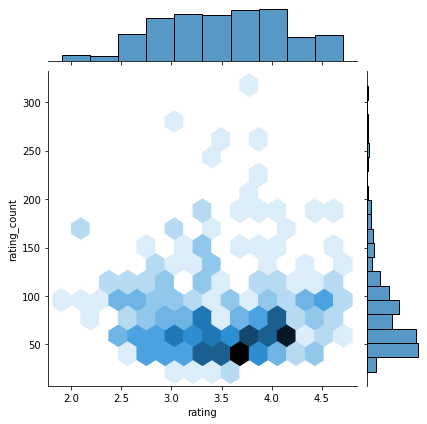

In [ ]:
sns.jointplot(data=df_wh, x="rating", y="rating_count", kind="hex")

In [ ]:
# Compute the Bayesian average
m = 3.6 # the value toward which we will adjust the average review of products with very few reviews
C = 60  # the number of reviews required to "get away from m"
sum_stars = df_wh['rating'] * df_wh['rating_count']
df_wh['rating'] = (C*m + sum_stars) / (C + df_wh['rating_count'])  # exact formula for Bayesian average
df_wh['rating'] = df_wh['rating'].round(2)  # round to two decimal places

## 4. Add accommodation counts

The values here were copied by hand

In [ ]:
# Bed and breakfast
ACCOM_COUNTS_BB = {
    'Angus': 24,
    'Argyll': 58,
    'Cairngorms': 37,
    'Fort William': 72,
    'Isle of Mull': 9,
    'Isle of Skye': 50,
    'Kintail': 3,
    'Loch Lomond': 33,
    'Loch Ness': 69,
    'Perthshire': 58,
    'Sutherland': 33,
    'Torridon': 9, 
    'Ullapool': 24
}

In [ ]:
df_wh['bb_count'] = df_wh['region'].map(ACCOM_COUNTS_BB)

In [ ]:
# Hotels
ACCOM_COUNTS_HOTELS = {
    'Angus': 24,
    'Argyll': 67,
    'Cairngorms': 29,
    'Fort William': 41,
    'Isle of Mull': 3,
    'Isle of Skye': 28,
    'Kintail': 3,
    'Loch Lomond': 35,
    'Loch Ness': 55,
    'Perthshire': 71,
    'Sutherland': 33,
    'Torridon': 10, 
    'Ullapool': 16
}

In [ ]:
df_wh['hotel_count'] = df_wh['region'].map(ACCOM_COUNTS_HOTELS)
df_wh['hotel_count'].isnull().any()

False

In [ ]:
# Hostels
ACCOM_COUNTS_HOSTELS = {
    'Angus': 1,
    'Argyll': 6,
    'Cairngorms': 9,
    'Fort William': 18,
    'Isle of Mull': 3,
    'Isle of Skye': 11,
    'Kintail': 1,
    'Loch Lomond': 7,
    'Loch Ness': 11,
    'Perthshire': 5,
    'Sutherland': 4,
    'Torridon': 6, 
    'Ullapool': 5
}

In [ ]:
df_wh['hostel_count'] = df_wh['region'].map(ACCOM_COUNTS_HOSTELS)
df_wh['hostel_count'].isnull().any()

False

In [ ]:
# Cottages
ACCOM_COUNTS_COTTAGES = {
    'Angus': 24,
    'Argyll': 101,
    'Cairngorms': 182,
    'Fort William': 147,
    'Isle of Mull': 41,
    'Isle of Skye': 188,
    'Kintail': 41,
    'Loch Lomond': 54,
    'Loch Ness': 97,
    'Perthshire': 96,
    'Sutherland': 49,
    'Torridon': 89,
    'Ullapool': 72
}

In [ ]:
df_wh['cottage_count'] = df_wh['region'].map(ACCOM_COUNTS_COTTAGES)
df_wh['cottage_count'].isnull().any()

False

In [ ]:
# Camping
ACCOM_COUNTS_CAMPING = {
    'Angus': 0,
    'Argyll': 0,
    'Cairngorms': 4,
    'Fort William': 8,
    'Isle of Mull': 0,
    'Isle of Skye': 7,
    'Kintail': 0,
    'Loch Lomond': 1,
    'Loch Ness': 12,
    'Perthshire': 5,
    'Sutherland': 6,
    'Torridon': 2,
    'Ullapool': 5
}

In [ ]:
df_wh['camping_count'] = df_wh['region'].map(ACCOM_COUNTS_COTTAGES)
df_wh['camping_count'].isnull().any()

False

## Join with the DoBIH database

### 1. Load and filter data and fix formatting

In [ ]:
# Load DB, keep relevant columns
relevant_cols = ['Number','Name','Metres','Island','County','M','Latitude','Longitude']
df_dobih = pd.read_csv('datasets/DoBIH_v17_1.csv', index_col='Number', usecols=relevant_cols)

In [ ]:
# Keep only Munros
munro_mask = df_dobih['M'] == 1
df_dobih = df_dobih.loc[munro_mask]
df_dobih.reset_index(inplace=True,drop=True)

In [ ]:
# Fix format of column names
df_dobih.rename(columns={'Metres': 'altitude'}, inplace=True)
df_dobih.columns = df_dobih.columns.str.lower().str.replace('-','_').str.replace(' ','_')

In [ ]:
# Remove text in [] at the end of names as this is just the pronunciation
re_square_brackets = r'\s\[.*\]'
df_dobih['name'] = df_dobih['name'].str.replace(re_square_brackets,'')

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# Round heights and convert to int, since that's what's used in Walk Highlands data
df_dobih['altitude'] = df_dobih['altitude'].round(0).astype(int)

In [ ]:
def fix_format(name):
    # For example:
    # 'Buachaille Etive Mor - Stob Dearg' -> 'Stob Dearg (Buachaille Etive Mor)'
    # 'Buachaille Etive Beag - Stob Dubh' -> 'Stob Dubh (Buachaille Etive Beag)'
    words = name.split(' - ')
    if len(words) > 1:
        name = f'{words[1]} ({words[0]})'
    return name

df_dobih['name'] = df_dobih['name'].apply(fix_format)

### 2. Align DoBIH Munro names with Walk Highlands naming

We will match based on a key - a stringified tuple consisting of Munro name and altitude. The data do not match exactly, so we will perform fuzzy matching. We will use `difflib` to help us find approximate matches for keys.

Even so, some of the differences in Munro naming are too significant to handle using an edit-distance-based method. We treat those now.

Note: The data from Walk Highlands will take priority.

In [ ]:
# Treat names that are too hard to match
hard_to_match = {
    'Glas Leathad Mor (Ben Wyvis)': 'Ben Wyvis',
    'Leabaidh an Daimh Bhuidhe (Ben Avon)': 'Ben Avon',
    'Meall nan Con (Ben Klibreck)': 'Ben Klibreck',
    "Carn nan Gabhar (Beinn a' Ghlo)": 'Carn nan Gabhar'
}
df_dobih['name'] = df_dobih['name'].replace(hard_to_match)

In [ ]:
# Fix problems with Munro altitude mismatches
# A counter-intuitive side-effect of using an edit-distance-based method 
# is that the numbers '1000' and '999' have quite a large edit distance
# unfortunately, some munros have altitude 1000 in one and 999 in the other
# dataset, and difflib failed to match those; we treat them below:

# Stob Ban
m = (df_dobih['name'] == 'Stob Ban') & (df_dobih['altitude'] == 1000)
df_dobih.loc[m, 'altitude'] = 999

# Sgurr Breac
m = (df_dobih['name'] == 'Sgurr Breac') & (df_dobih['altitude'] == 1000)
df_dobih.loc[m, 'altitude'] = 999

In [ ]:
# Treat duplicates
# The DoBIH database stores a shortened version of Munro names (e.g. Carn Dearg)
# unlike Walk Highlands. This results mismatches, so we treat it below:

# A' Chailleach
m = (df_dobih['name'] == "A' Chailleach") & (df_dobih['altitude'] == 929)
df_dobih.loc[m, 'name'] = "A' Chailleach (Monadhliath)"

# Carn Dearg
m = (df_dobih['name'] == "Carn Dearg") & (df_dobih['altitude'] == 1034)
df_dobih.loc[m, 'name'] = 'Carn Dearg (Loch Pattack)'

m = (df_dobih['name'] == "Carn Dearg") & (df_dobih['altitude'] == 946)
df_dobih.loc[m, 'name'] = 'Carn Dearg (Monadhliath)'

m = (df_dobih['name'] == "Carn Dearg") & (df_dobih['altitude'] == 941)
df_dobih.loc[m, 'name'] = 'Carn Dearg (Corrour)'

# Geal-charn
m = (df_dobih['name'] == 'Geal-charn') & (df_dobih['altitude'] == 917)
df_dobih.loc[m, 'name'] = 'Geal-charn (Drumochter)'

m = (df_dobih['name'] == 'Geal-charn') & (df_dobih['altitude'] == 1132)
df_dobih.loc[m, 'name'] = 'Geal-charn (Alder)'

# Geal Charn
m = (df_dobih['name'] == 'Geal Charn') & (df_dobih['altitude'] == 926)
df_dobih.loc[m, 'name'] = 'Geal Charn (Monadhliath)'

# Beinn a' Chaorainn
m = (df_dobih['name'] == "Beinn a' Chaorainn") & (df_dobih['altitude'] == 1083)
df_dobih.loc[m, 'name'] = "Beinn a' Chaorainn (Cairngorms)"

m = (df_dobih['name'] == "Beinn a' Chaorainn") & (df_dobih['altitude'] == 1049)
df_dobih.loc[m, 'name'] = "Beinn a' Chaorainn (Glen Spean)"

# Beinn Dearg
m = (df_dobih['name'] == 'Beinn Dearg') & (df_dobih['altitude'] == 1009)
df_dobih.loc[m, 'name'] = 'Beinn Dearg (Blair Atholl)'

m = (df_dobih['name'] == 'Beinn Dearg') & (df_dobih['altitude'] == 1084)
df_dobih.loc[m, 'name'] = 'Beinn Dearg (Ullapool)'

# Sgurr nan Coireachan
m = (df_dobih['name'] == 'Sgurr nan Coireachan') & (df_dobih['altitude'] == 954)
df_dobih.loc[m, 'name'] = 'Sgurr nan Coireachan (Glen Dessary)'

m = (df_dobih['name'] == 'Sgurr nan Coireachan') & (df_dobih['altitude'] == 956)
df_dobih.loc[m, 'name'] = 'Sgurr nan Coireachan (Glenfinnan)'

# Carn nan Gobhar
    # Note: using data from Walk Highlands
    # Carn nan Gobhar (Strathfarrar): longitde = -4.8800484; latitude =57.4525364
    # Carn nan Gobhar (Loch Mullardoch): longitde = -5.0244477; latitude =57.3633406
m = (df_dobih['name'] == 'Carn nan Gobhar') & (df_dobih['longitude'].round(2) == -4.88)
df_dobih.loc[m, 'name'] = 'Carn nan Gobhar (Strathfarrar)'

m = (df_dobih['name'] == 'Carn nan Gobhar') & (df_dobih['longitude'].round(2) == -5.02)
df_dobih.loc[m, 'name'] = 'Carn nan Gobhar (Loch Mullardoch)'

### 3. Generate keys

Munro name and altitude are the only fields are the only fields that are common to both datasets. Hence, a key will be the tuple `(<munro_name>, <munro_altitude>)`, stringified. 

In [ ]:
key_tuples = list(zip(df_wh['name'].str.replace(' ',''), df_wh['altitude']))
keys = list(map(str, key_tuples))
df_wh['key'] = keys
df_wh['key'].head()

0              ('BenNevis', 1345)
1             ('BenMacdui', 1309)
2             ('Braeriach', 1296)
3             ('CairnToul', 1291)
4    ('SgoranLochainUaine', 1258)
Name: key, dtype: object

In [ ]:
key_tuples = list(zip(df_dobih['name'].str.replace(' ',''), df_dobih['altitude']))
keys = list(map(str, key_tuples))
df_dobih['key'] = keys
df_dobih['key'].head()

0      ('BenChonzie', 931)
1      ('BenVorlich', 985)
2    ("Stuca'Chroin", 973)
3        ('BenMore', 1174)
4    ('StobBinnein', 1165)
Name: key, dtype: object

In [ ]:
# Verify that all keys are unique
no_dupes_in_wh = not df_wh['key'].duplicated(keep=False).any()
no_dupes_in_dobih = not df_dobih['key'].duplicated(keep=False).any()
no_dupes_in_wh and no_dupes_in_dobih

True

### 4. Verify approximate key pairs

In [ ]:
# Verify suggested approximate matches
from ast import literal_eval as make_tuple
def _possible_mismatch(x):  # method that looks for possible key mismatches
    n1,a1 = make_tuple(x['wh_key'])
    n2,a2 = make_tuple(x['dobih_key'])
    n1 = n1.lower()
    n2 = n2.lower()
    return (n1 not in n2 and n2 not in n1) or abs(a2-a1) > 10

# Create a dummy dataframe to hold the matched key pairs
df_temp = pd.DataFrame()
df_temp['wh_key'] = df_wh['key']
# Fuzzy match Walk Highlands keys against DoBIH keys
df_temp['dobih_key'] = df_wh['key'].apply(lambda x: difflib.get_close_matches(x, df_dobih['key'])[0])

# Show suggested approximate matches for keys that don't have an exact match
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    m = df_temp.apply(_possible_mismatch, axis=1)
    display(df_temp.loc[m])

,wh_key,dobih_key
11,"('CarnEige', 1183)","('CarnEighe', 1183)"
21,"('SgurrnanCeathreamhnan', 1151)","('SgurrnanCeathramhnan', 1151)"
32,"(""A'Chralaig"", 1120)","(""A'Chraileag"", 1120)"
61,"('BeinnHeasgarnich', 1078)","('BeinnSheasgarnaich', 1077)"
89,"('StobCoiranAlbannaich', 1044)","(""StobCoir'anAlbannaich"", 1044)"
105,"('BenChallum', 1025)","('BeinnChalluim', 1025)"
148,"('Sgornah-Ulaidh', 994)","('Sgurrnah-Ulaidh', 994)"
163,"('SgurrMor(BeinnAlligin)', 986)","('SgurrMhor(BeinnAlligin)', 986)"
189,"('SgurrnaBanachdich', 965)","('SgurrnaBanachdaich', 965)"
196,"('StuchdanLochain', 960)","('StucanLochain', 960)"


These all look sensible, so we may perform matching on them.

### 5. Perform fuzzy matching

In [ ]:
# Fuzzy match Walk Highlands keys against DoBIH keys
closest_dobih_key_match = lambda x: difflib.get_close_matches(x, df_dobih['key'])[0]
df_wh['key_fuzzy'] = df_wh['key'].apply(closest_dobih_key_match)

In [ ]:
# Merge Walk Highlands and DoBIH datasets
df_merged = df_wh.merge(df_dobih, left_on='key_fuzzy', right_on='key', suffixes=['_wh','_dobih'])

In [ ]:
# Drop irrelevant columns
df_merged.drop(columns=['key_wh','key_fuzzy','key_dobih','altitude_dobih','name_dobih','m'], inplace=True)

In [ ]:
# Strip the "_wh"-suffix
df_merged.rename(columns=lambda x: x[:-3] if x.endswith('_wh') else x, inplace=True)

### 6. Compute the number of neighboring munros

In [ ]:
radii = [0, 5, 20]

In [ ]:
# Inspiration drawn from: 
# https://medium.com/@danalindquist/finding-the-distance-between-two-lists-of-geographic-coordinates-9ace7e43bb2f
EARTH_RADIUS_KM = 6371  # TODO: change if we go for miles instead of km
# We use the haversine formula to calculate the differnece 
# between two points on a sphere (Earth) 
dist = sklearn.neighbors.DistanceMetric.get_metric('haversine')

def count_neighbors_within(inner_radius, outer_radius, df):
    # Return a n*n dataframe with munro names as column and index names which 
    # stores the distance for each munro combination

    # Convert latitude and longitude to radians (haversine expects radians)
    from_ = df[['latitude','longitude']].applymap(np.radians)
    to = from_  # since we consider distances for munro-munro pairs
    # Calculate pairwise distances and scale up from unit sphere to the size of Earth
    dist_matrix = dist.pairwise(from_, to) * EARTH_RADIUS_KM
    dist_matrix = pd.DataFrame(dist_matrix, columns=df['name'], index=df['name'])
    # Compute number of neighbors within a distance for each row
    within_ring = ((inner_radius < dist_matrix) & (dist_matrix <= outer_radius))
    neighbor_counts = within_ring.sum().values
    return neighbor_counts

In [ ]:
# for radius in radii:
for inner_radius, outer_radius in zip(radii, radii[1:]):
    col_name = f'neighbor_count_{inner_radius}_{outer_radius}'
    for island in df_merged['island'].unique():
        if pd.isnull(island):
            m = df_merged['island'].isnull()
        else:
            m = df_merged['island'] == island
        df_merged.loc[m, col_name] = count_neighbors_within(inner_radius, outer_radius, df_merged.loc[m])
    df_merged[col_name] = df_merged[col_name].astype(int)  # correct the data type

## Join with cities database

In [ ]:
df_cities = pd.read_csv('datasets/worldcities.csv')

In [ ]:
# Keep UK cities only
df_cities = df_cities.loc[df_cities['country'] == 'United Kingdom']

# Filter out very small cities
df_cities = df_cities[df_cities['population'] >= 100]

### 1. Compute distance to nearest city

In [ ]:
def compute_city_distances(df_merged, df_cities):
    # Convert latitude and longitude to radians (haversine expects radians)
    from_ = df_merged[['latitude','longitude']].applymap(np.radians)
    to = df_cities[['lat','lng']].applymap(np.radians)
    # Calculate pairwise distances and scale up from unit sphere to the size of Earth
    dist_matrix = dist.pairwise(from_, to) * EARTH_RADIUS_KM
    dist_matrix = pd.DataFrame(dist_matrix, columns=df_cities['city'], index=df_merged['name'])
    return dist_matrix

In [ ]:
city_distances = compute_city_distances(df_merged, df_cities)

In [ ]:
# min is column-wise; we wish to apply it to rows, so we take the transpose of the dataframe
df_merged['nearest_city_dist'] = city_distances.T.min().round(2).values

### 2. Compute population of nearest city

In [ ]:
def population_of_nearest_city(row):
    nearest_city = row.idxmin()
    population = df_cities.loc[df_cities['city'] == nearest_city, 'population']
    population = int(population)
    return population

In [ ]:
df_merged['nearest_city_population'] = city_distances.apply(population_of_nearest_city, axis=1).values

### 3. Compute distance to nearest large city

In [ ]:
# Create a dataframe with large cities only
large_cities = df_cities.loc[df_cities['population'] >= 50_000]
large_city_distances = compute_city_distances(df_merged, large_cities)

### 4. Compute sum of populations of cities within a radius

In [ ]:
radii = [0, 25, 50, 75, 100]

In [ ]:
def population_within(inner_radius, outer_radius, row):
    cities = row[(inner_radius < row) & (row <= outer_radius)].index
    population = df_cities.loc[df_cities['city'].isin(cities), 'population'].sum()
    population = int(population)
    return population

In [ ]:
for inner_radius, outer_radius in zip(radii, radii[1:]):
    col_name = f'population_{inner_radius}_{outer_radius}'
    df_merged[col_name] = city_distances.apply(lambda row: population_within(inner_radius, outer_radius, row), axis=1).values

## Add data about beginner-friendliness

In [ ]:
# name = 'BHEINN'.lower()
# df_merged.loc[df_merged['name'].str.lower().str.contains(name), 'name']

In [ ]:
mentioned_in_visit_scotland = ['Ben Lomond', 'Schiehallion', 'Ben Chonzie', 'Ben Vorlich (Loch Lomond)', 'Cairn Gorm', 
                                'Mayar', 'Driesh', 'Mount Keen', 'Broad Cairn', 'Ben Wyvis', 'Fionn Bheinn']

In [ ]:
df_merged['beginner_friendly'] = df_merged['name'].isin(mentioned_in_visit_scotland)

# Convert True to 1 and False to 0
df_merged['beginner_friendly'] = df_merged['beginner_friendly'].astype(int)

## Add data about national parks

In [ ]:
df_merged['region'].unique()

array(['Fort William', 'Cairngorms', 'Perthshire', 'Loch Ness',
       'Loch Lomond', 'Argyll', 'Kintail', 'Ullapool', 'Torridon',
       'Isle of Skye', 'Isle of Mull', 'Sutherland', 'Angus'],
      dtype=object)

In [ ]:
# Identify regions corresponding to national parks
national_park_regions = ['Loch Lomond', 'Cairngorms']
national_park_mask = df_merged['region'].isin(national_park_regions)

df_merged['national_park'] = df_merged.loc[national_park_mask, 'region']

# Use official name
df_merged['national_park'].replace('Loch Lomond', 'Loch Lomond and The Trossachs', inplace=True)

## Add data about 

## Export dataset

In [ ]:
df_merged.to_csv('datasets/clean.csv', index=False)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ad6e5521-2329-4ba2-9ce8-c0f71fb15c68' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>